# Notice

I aims to reproduce the Figure 3.(g) in paper: 

Design of an amplitude-splitting hard x-ray delay line with subnanoradian stability

However, the figures in that paper is not produced by this package.

In [1]:
import sys
import time
sys.path.append(r"C:\Users\haoyuan\Desktop\LCLS Project\Defense\code\XRaySimulation-tmp\XRaySimulation")

import numpy as np
import matplotlib.pyplot as plt

from XRaySimulation import util, Pulse, Crystal, MultiDevice
from XRaySimulation.GPU import GPUMultiDevice

# Define The pulse

In [2]:
energy_center_keV = 10.  # keV
pre_length = 1.    # Distance between the pulse (0,0,-pre_length) and the origin (0,0,0) of the reference frame

# Set up the pulse
intensity_FWHM = 50. #e-6 # (m)
field_sigma = util.intensity_fwhm_to_field_sigma(intensity_FWHM)

intensity_duration_FWHM = 20e-15 # fs
field_duration_sigma = util.intensity_fwhm_to_field_sigma(intensity_duration_FWHM)

my_pulse = Pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center_keV,
                              polar=[1., 0., 0.],
                              sigma_x= field_sigma / util.c,  # fs
                              sigma_y= field_sigma / util.c,  # fs
                              sigma_z= 2., #field_duration_sigma,  # fs
                              x0=np.array([0., 0., -pre_length]))

# Define the gratings

In [3]:
grating_list = [Crystal.RectangleGrating(), Crystal.RectangleGrating()]
grating_list[0].set_a(0.5)
grating_list[0].set_b(0.5)
grating_list[1].set_a(0.5)
grating_list[1].set_b(0.5)

dtheta = np.arctan(grating_list[0].base_wave_vector[1] / my_pulse.klen0)  # This is the deviation angle.

# Define the Crystals for the Reference Branch

In [4]:
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi_dict = {"chi0":complex(-0.97631E-05, 0.14871E-06),
            "chih_sigma":complex(0.59310E-05, -0.14320E-06),
            "chihbar_sigma":complex(0.59310E-05, -0.14320E-06),
            "chih_pi":complex(0.46945E-05, -0.11201E-06),
            "chihbar_pi":complex(0.46945E-05, -0.11201E-06)
           }

miscut = np.zeros(4)

# Create 8 crystal list
crystal_list_1 = [Crystal.CrystalBlock3D(h=np.array([0, h_length, 0]),
                                         normal=-np.array([0, np.cos(miscut[x]), np.sin(miscut[x])]),
                                         surface_point=np.zeros(3),
                                         thickness=1e6,
                                         chi_dict=chi_dict) for x in range(4)]

# Align crystals in the reference branch

In [5]:
# Get the wave vector from the first grating
"""
Assume that the -1 order goes to the reference branch
"""
kout_g_1 = my_pulse.k0 + grating_list[0].base_wave_vector

# Align the 1st crystal
util.align_crystal_dynamical_bragg_reflection(crystal = crystal_list_1[0],
                                              kin = kout_g_1,
                                              rot_direction= 1.,
                                              scan_range=0.0005,
                                              scan_number=10000)

# Align the 2nd crystal
util.align_crystal_reciprocal_lattice(crystal=crystal_list_1[1],
                                      axis= -crystal_list_1[0].h)

# Get the output from the first two crystals
kout_cc_1 = MultiDevice.get_kout(device_list=crystal_list_1[:2],
                                 kin=kout_g_1)


# Align the 3rd crystal
util.align_crystal_dynamical_bragg_reflection(crystal = crystal_list_1[2],
                                              kin = kout_cc_1[-1],
                                              rot_direction= -1.,
                                              scan_range=0.0005,
                                              scan_number=10000)

# Align the 4th crystal
util.align_crystal_reciprocal_lattice(crystal=crystal_list_1[3],
                                      axis= -crystal_list_1[2].h)

# Get the output from the two channel-cuts
kout_cc_2 = MultiDevice.get_kout(device_list=crystal_list_1,
                                 kin=kout_g_1)

# Set crystal positions for the reference branch

In [6]:
# Get directions
directions = kout_cc_2 / util.l2_norm_batch(kout_cc_2)[:, np.newaxis]

for d in directions:
    print(d)

[0.00000000e+00 1.23984196e-04 9.99999992e-01]
[ 0.         -0.61106404  0.79158117]
[0.00000000e+00 1.23984196e-04 9.99999992e-01]
[0.         0.61126031 0.79142962]
[0.00000000e+00 1.23984196e-04 9.99999992e-01]


In [7]:
# Start from the position of the center of the first grating (0,0,0)
surface_point = np.zeros(3)

# Assume that the path length between the first grating and the first crystal is 5m
surface_point += directions[0] * 5e6   
crystal_list_1[0].set_surface_point(surface_point=np.copy(surface_point))

# Assume that the path length, not the gap size, between the first reflection surface and the second is 5cm
surface_point += directions[1] * 0.05e6
crystal_list_1[1].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 30cm
surface_point += directions[2] * 0.5e6
crystal_list_1[2].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 5.5cm
surface_point += directions[3] * 0.055e6
crystal_list_1[3].set_surface_point(surface_point=np.copy(surface_point))

# Define crystals for the Delay Branch

In [8]:
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi_dict = {"chi0":complex(-0.97631E-05, 0.14871E-06),
            "chih_sigma":complex(0.59310E-05, -0.14320E-06),
            "chihbar_sigma":complex(0.59310E-05, -0.14320E-06),
            "chih_pi":complex(0.46945E-05, -0.11201E-06),
            "chihbar_pi":complex(0.46945E-05, -0.11201E-06)
           }

miscut = np.array([0, np.deg2rad(5), -np.deg2rad(5), 0 ,
                   0, -np.deg2rad(5), np.deg2rad(5), 0 ], dtype=np.float64)

# Create 8 crystal list
crystal_list_2 = [Crystal.CrystalBlock3D(h=np.array([0, h_length, 0]),
                                         normal=-np.array([0, np.cos(miscut[x]), np.sin(miscut[x])]),
                                         surface_point=np.zeros(3),
                                         thickness=1e6,
                                         chi_dict=chi_dict) for x in range(8)]

# Align the crystals in the Delayed branch

In [9]:
# Get the wave vector from the first grating
"""
Assume that the 1 order goes to the reference branch
"""
kout_g_2 = my_pulse.k0 - grating_list[0].base_wave_vector

#############################################################
#            First CC
#############################################################
# Align the 1st crystal
util.align_crystal_dynamical_bragg_reflection(crystal = crystal_list_2[0],
                                              kin = kout_g_2,
                                              rot_direction= -1.,
                                              scan_range=0.0005,
                                              scan_number=10000)

# Align the 2nd crystal
util.align_crystal_reciprocal_lattice(crystal=crystal_list_2[1],
                                      axis= -crystal_list_2[0].h)

# Get the output from the first two crystals
kout_cc_1 = MultiDevice.get_kout(device_list=crystal_list_2[:2],
                                 kin=kout_g_2)

#############################################################
#            Second CC
#############################################################
# Align the 3rd crystal
util.align_crystal_dynamical_bragg_reflection(crystal = crystal_list_2[2],
                                              kin = kout_cc_1[-1],
                                              rot_direction= 1.,
                                              scan_range=0.0005,
                                              scan_number=10000)

# Align the 4th crystal
util.align_crystal_reciprocal_lattice(crystal=crystal_list_2[3],
                                      axis= -crystal_list_2[2].h)

# Get the output from the two channel-cuts
kout_cc_2 = MultiDevice.get_kout(device_list=crystal_list_2[:4],
                                 kin=kout_g_2)

#############################################################
#            Thrid CC
#############################################################
# Align the 5st crystal
util.align_crystal_dynamical_bragg_reflection(crystal = crystal_list_2[4],
                                              kin = kout_cc_2[-1],
                                              rot_direction= 1.,
                                              scan_range=0.0005,
                                              scan_number=10000)

# Align the 6nd crystal
util.align_crystal_reciprocal_lattice(crystal=crystal_list_2[5],
                                      axis= -crystal_list_2[4].h)

# Get the output from the first two crystals
kout_cc_3 = MultiDevice.get_kout(device_list=crystal_list_2[:6],
                                 kin=kout_g_2)

#############################################################
#            Fourth CC
#############################################################
# Align the 7rd crystal
util.align_crystal_dynamical_bragg_reflection(crystal = crystal_list_2[6],
                                              kin = kout_cc_3[-1],
                                              rot_direction= -1.,
                                              scan_range=0.0005,
                                              scan_number=10000)

# Align the 8th crystal
util.align_crystal_reciprocal_lattice(crystal=crystal_list_2[7],
                                      axis= -crystal_list_2[6].h)

# Get the output from the two channel-cuts
kout_cc_4 = MultiDevice.get_kout(device_list=crystal_list_2,
                                 kin=kout_g_2)

# Set crystal positions for Delayed branch

In [10]:
# Get directions
directions_delay = kout_cc_4 / util.l2_norm_batch(kout_cc_4)[:, np.newaxis]

for d in directions_delay:
    print(d)

[ 0.00000000e+00 -1.23984196e-04  9.99999992e-01]
[0.         0.61106404 0.79158117]
[ 0.00000000e+00 -1.34778655e-04  9.99999991e-01]
[ 0.         -0.61127062  0.79142165]
[ 0.0000000e+00 -1.4337804e-04  9.9999999e-01]
[ 0.         -0.61127565  0.79141776]
[ 0.00000000e+00 -1.32583581e-04  9.99999991e-01]
[0.         0.611059   0.79158506]
[ 0.00000000e+00 -1.23984196e-04  9.99999992e-01]


In [11]:
# Start from the position of the center of the first grating (0,0,0)
surface_point = np.zeros(3)

# Assume that the path length between the first grating and the first crystal is 5m
surface_point += directions_delay[0] * 5.1e6   
crystal_list_2[0].set_surface_point(surface_point=np.copy(surface_point))

# Assume that the path length, not the gap size, between the first reflection surface and the second is 2.5cm
surface_point += directions_delay[1] * 0.025e6
crystal_list_2[1].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 10cm
surface_point += directions_delay[2] * 0.1e6
crystal_list_2[2].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 2.5cm
surface_point += directions_delay[3] * 0.025e6
crystal_list_2[3].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 10cm
surface_point += directions_delay[4] * 0.1e6
crystal_list_2[4].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 2.5cm
surface_point += directions_delay[5] * 0.025e6
crystal_list_2[5].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 10cm
surface_point += directions_delay[6] * 0.1e6
crystal_list_2[6].set_surface_point(surface_point=np.copy(surface_point))

# Path length is 3cm
surface_point += directions_delay[7] * 0.035e6
crystal_list_2[7].set_surface_point(surface_point=np.copy(surface_point))

# Scan the position of the second grating so that the two pulse cross

In [12]:
# By simple math, one can prove that the crossing position can be find in the following manner.
d_tmp = np.cross(directions[-1], crystal_list_1[-1].surface_point - crystal_list_2[-1].surface_point)
d_tmp = util.l2_norm(d_tmp) / util.l2_norm(np.cross(directions[-1], directions_delay[-1]))

grating_list[1].set_surface_point(crystal_list_2[-1].surface_point + d_tmp * directions_delay[-1])

# Define the Final observation point

In [13]:
observation = grating_list[1].surface_point + np.array([0,0,1e6])

# Get the path length for each branch

In [14]:
################################################
#       The reference branch
################################################
# Manually set the grating diffraction order
grating_list[0].set_diffraction_order(1)
grating_list[1].set_diffraction_order(-1)

device_list_reference = [grating_list[0],] + crystal_list_1 + [grating_list[1]]

(intersection_list_ref,
kout_list_ref,
path_length_ref) = MultiDevice.get_lightpath(device_list = device_list_reference,
                                     kin = my_pulse.k0, 
                                     initial_point = my_pulse.x0,
                                     final_plane_point = observation,
                                     final_plane_normal = np.array([0,0,1], dtype = np.float64))

################################################
#       The delayed branch
################################################
device_list_delayed = [grating_list[0],] + crystal_list_2 + [grating_list[1]]

# Manually set the grating diffraction order
grating_list[0].set_diffraction_order(-1)
grating_list[1].set_diffraction_order(1)

(intersection_list_delayed,
kout_list_delayed,
path_length_delayed) = MultiDevice.get_lightpath(device_list = device_list_delayed,
                                             kin = my_pulse.k0, 
                                             initial_point = my_pulse.x0,
                                             final_plane_point = observation,
                                             final_plane_normal = np.array([0,0,1], dtype = np.float64))

print("The final kout of the reference branch is ")
print(kout_list_ref[-1])
print("The total path length of the reference branch is {:.2f} um".format(path_length_ref))

print("")
print("")

print("The final kout list of the delayed branch is ")
print(kout_list_delayed[-1])
print("The total path length of the delayed branch is {:.2f} um".format(path_length_delayed))

The final kout of the reference branch is 
[ 0.00000000e+00 -7.92788057e-12  5.06773076e+04]
The total path length of the reference branch is 13326341.51 um


The final kout list of the delayed branch is 
[ 0.00000000e+00 -5.42863532e-11  5.06773076e+04]
The total path length of the delayed branch is 13327383.21 um


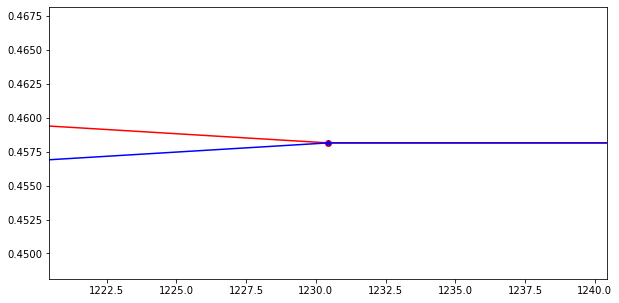

In [15]:
intersect_var = np.vstack(intersection_list_delayed)
intersect_fixed = np.vstack(intersection_list_ref)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_var[:,2]/1e4, intersect_var[:,1]/1e4,'ro-')
axes.plot(intersect_fixed[:,2]/1e4, intersect_fixed[:,1]/1e4,'b*-')

#axes.plot([0, 1300], [0,0])
axes.set_xlim([intersect_fixed[-2,2]/1e4 - 10, intersect_fixed[-2,2]/1e4 + 10])
axes.set_ylim([intersect_fixed[-2,1]/1e4 -0.01, intersect_fixed[-2,1]/1e4 + 0.01])
#axes.set_aspect('equal', 'datalim')

plt.show()

# Construct Momentum For simulation

In [16]:
observation

array([0.00000000e+00, 4.58136803e+03, 1.33044481e+07])

In [17]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 512
number_z = 2 ** 13
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                          number_y=number_y,
                                                          number_z=number_z,
                                                          delta_e_x=1e-50,
                                                          delta_e_y=5e-4,
                                                          delta_e_z=2e-3)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(ky_grid)
kz_grid = np.ascontiguousarray(kz_grid)

# Get the output field of the reference pulse

In [18]:
# Set the range of the index to save
d_num = 512

# -------------------------------------------------------------
#            Get Field for variable branch
# -------------------------------------------------------------
tic = time.time()

(result_3d, 
 reflectivty_holder,
 sanity_check
) = GPUMultiDevice.get_diffracted_spectrum_with_gaussian_source(crystal_list = device_list_reference,
                                                             total_path = path_length_ref,
                                                             observation = observation,
                                                             my_pulse = my_pulse,
                                                             pulse_delay_time = 0.,
                                                             pulse_k0_final= kout_list_ref[-1],
                                                             grating_orders = [1,-1],
                                                             kx_grid = kx_grid,
                                                             ky_grid = ky_grid,
                                                             kz_grid = kz_grid,
                                                             number_x = number_x,
                                                             number_y = number_y,
                                                             number_z = number_z,
                                                             d_num=d_num)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.01 seconds to prepare the variables.
It takes 12.34 seconds to get the field for branch 1.


# Analyze the field

In [19]:
spectrum = result_3d["efield_spec_3d"][0,:,:,0]
field = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(spectrum)))

spectrum_intensity = np.square(np.abs(spectrum))
intensity = np.square(np.abs(field))

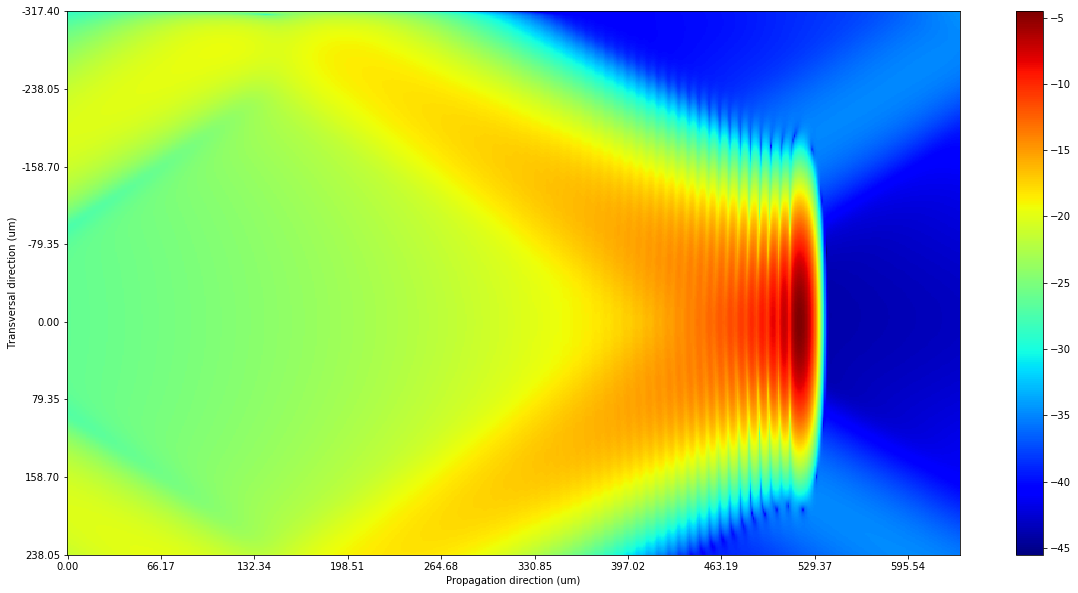

In [20]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(20)

im = axes.imshow(np.log(intensity[:,2 ** 12 - 2** 9 : 2 ** 12 + 100]),
                  cmap='jet',
                  aspect="auto")

#axes.set_title("Time response for R0H")
yposition = np.arange(0, 512, 64)
yticks_tmp = (yposition - 256) * (axis_info['y_idx'][1] - axis_info['y_idx'][0])
yticks = ["{:.2f}".format(x) for x in yticks_tmp]

xposition = np.arange(0, 2 ** 9 + 100, 64)
xticks_tmp = xposition * (axis_info['z_time_idx'][1] - axis_info['z_time_idx'][0])
xticks = ["{:.2f}".format(x) for x in xticks_tmp]


axes.set_yticks(yposition)
axes.set_yticklabels(yticks)
axes.set_xticklabels(xticks)
axes.set_xticks(xposition)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (um)")
fig.colorbar(im, ax=axes )#, format='$%.2f$')
# Show the canvas
#plt.axis('off')
plt.show()

In [21]:
from matplotlib.colors import LogNorm
plt.rc('text',usetex=True)
font = {'family':"Times New Roman",'size':16,'weight':'normal'}
plt.rc('font',**font)
plt.rc('legend',**{'fontsize':14})

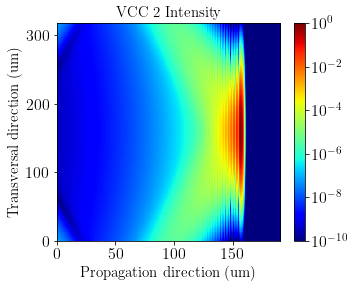

In [24]:
dz = (axis_info['z_time_idx'][1] - axis_info['z_time_idx'][0])
dy = (axis_info['y_idx'][1] - axis_info['y_idx'][0])

# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(4)
fig.set_figwidth(5)


#field_fix = np.roll(np.fft.ifftshift(np.fft.ifft(result_2d_var['x_field_2d'], axis=0), axes=0),
#                   shift=0, axis=0)
#intensity = np.square(np.abs(field_fix)[200:500,400:])
#intensity /= np.max(intensity)

intensity_to_plot = intensity[128:128*3,2 ** 12 - 2** 9 : 2 ** 12 + 100]
intensity_to_plot /= np.max(intensity_to_plot)

im = axes.imshow(intensity_to_plot,
                  cmap='jet',
                  norm=LogNorm(vmin=1e-10, vmax=1),
                  extent=[0, intensity_to_plot.shape[1] * dz * util.c, 0, intensity_to_plot.shape[0] * dy],
                  aspect="auto",
                  origin="lower")

axes.set_xlabel("Propagation direction (um)", fontsize=15)
axes.set_ylabel("Transversal direction (um)", fontsize=15)
axes.set_title("VCC 2 Intensity", fontsize=15)

fig.colorbar(im, ax=axes)#, format='$%.2f$')
plt.show()